In [69]:
import pandas as pd
import json
import pprint
import ast
import matplotlib.pyplot as plt
import gzip
from itertools import chain
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.prediction_algorithms import SVD, knns, KNNWithMeans, KNNBasic, KNNBaseline, KNNWithZScore, CoClustering, BaselineOnly, NormalPredictor, NMF, SVDpp, SlopeOne
from surprise.model_selection import GridSearchCV
import numpy as np
import seaborn as sns
import torch
#from fastai import *
#from fastai.column_data import *
#from fastai.imports import *

# Retreive the data and create DataFrames for the files

In [2]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [3]:
data_test = parse('australian_user_reviews.json.gz')

In [4]:
data_test

<generator object parse at 0x7fdf87030270>

In [5]:
full_data = parse('steam_reviews.json.gz')

In [6]:
full_data

<generator object parse at 0x7fdf87030580>

In [7]:
game_data = parse('steam_games.json.gz')

In [8]:
game_data

<generator object parse at 0x7fdf87030890>

In [9]:
item_data = parse('australian_users_items.json.gz')

In [10]:
test_df = pd.DataFrame(data_test)

In [11]:
# df = pd.DataFrame(full_data)

In [12]:
game_df = pd.DataFrame(game_data)

In [13]:
item_df = pd.DataFrame(item_data)

In [14]:
game_df

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32130,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",1.49,http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,False,773640,"Nikita ""Ghost_RUS""",NaN,NaN
32131,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",4.24,http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,False,733530,Sacada,NaN,NaN
32132,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",1.39,http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660,Laush Dmitriy Sergeevich,NaN,NaN
32133,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",NaN,http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,False,658870,"xropi,stev3ns",1 user reviews,NaN


In [15]:
test_df

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."
2,evcentric,http://steamcommunity.com/id/evcentric,"[{'funny': '', 'posted': 'Posted February 3.',..."
3,doctr,http://steamcommunity.com/id/doctr,"[{'funny': '', 'posted': 'Posted October 14, 2..."
4,maplemage,http://steamcommunity.com/id/maplemage,"[{'funny': '3 people found this review funny',..."
...,...,...,...
25794,76561198306599751,http://steamcommunity.com/profiles/76561198306...,"[{'funny': '', 'posted': 'Posted May 31.', 'la..."
25795,Ghoustik,http://steamcommunity.com/id/Ghoustik,"[{'funny': '', 'posted': 'Posted June 17.', 'l..."
25796,76561198310819422,http://steamcommunity.com/profiles/76561198310...,"[{'funny': '1 person found this review funny',..."
25797,76561198312638244,http://steamcommunity.com/profiles/76561198312...,"[{'funny': '', 'posted': 'Posted July 21.', 'l..."


In [16]:
item_df

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."
...,...,...,...,...,...
88305,76561198323066619,22,76561198323066619,http://steamcommunity.com/profiles/76561198323...,"[{'item_id': '413850', 'item_name': 'CS:GO Pla..."
88306,76561198326700687,177,76561198326700687,http://steamcommunity.com/profiles/76561198326...,"[{'item_id': '11020', 'item_name': 'TrackMania..."
88307,XxLaughingJackClown77xX,0,76561198328759259,http://steamcommunity.com/id/XxLaughingJackClo...,[]
88308,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...,"[{'item_id': '304930', 'item_name': 'Unturned'..."


In [17]:
test_df['reviews'][0]

[{'funny': '',
  'posted': 'Posted November 5, 2011.',
  'last_edited': '',
  'item_id': '1250',
  'helpful': 'No ratings yet',
  'recommend': True,
  'review': 'Simple yet with great replayability. In my opinion does "zombie" hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth "zombie" splattering fun for the whole family. Amazed this sort of FPS is so rare.'},
 {'funny': '',
  'posted': 'Posted July 15, 2011.',
  'last_edited': '',
  'item_id': '22200',
  'helpful': 'No ratings yet',
  'recommend': True,
  'review': "It's unique and worth a playthrough."},
 {'funny': '',
  'posted': 'Posted April 21, 2011.',
  'last_edited': '',
  'item_id': '43110',
  'helpful': 'No ratings yet',
  'recommend': True,
  'review': 'Great atmosphere. The gunplay can be a bit chunky at times but at the end of the day this game is definitely worth it and I hope they do a sequel...so buy the game so I get a sequel!'}]

In [18]:
# item_df['items'][1]

In [19]:
game_ids = [ids for ids in item_df['items'][0][0]['item_id']]

In [20]:
game_ids

['1', '0']

In [21]:
# for ids in range(0,len(game_ids)):
#     int(item_df['items'][0][ids]['item_id'])
#     for game_id in int(item_df['items'][0][ids]['item_id']:
#         all_game_id.append(game_id)

# Data Cleaning

This saves all of the game ids a user has into a 2d list - this will be used to save the info for the rec system

In [22]:
all_game_id = []
for ids in item_df['items']:
    temp_list = []
    for count in range(len(ids)):
        #print(ids[count]['item_id'])
        temp_list.append(int(ids[count]['item_id']))
    #print(temp_list)
    all_game_id.append(temp_list)
    #print(len(ids))

In [23]:
len(all_game_id[1])

888

In [24]:
item_df['game_ids'] = all_game_id

In [25]:
item_df.head()

,user_id,items_count,steam_id,user_url,items,game_ids
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik...","[10, 20, 30, 40, 50, 60, 70, 130, 300, 240, 38..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik...","[10, 80, 100, 300, 30, 40, 60, 240, 280, 360, ..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest...","[1200, 1230, 1280, 1520, 220, 320, 340, 360, 3..."
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik...","[10, 20, 30, 40, 50, 60, 70, 130, 80, 100, 300..."
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea...","[300, 20, 50, 70, 130, 10, 30, 40, 60, 80, 100..."


Create a new column called user_ids to replace the old user id

In [26]:
item_df['user_ids'] = item_df.index

In [27]:
item_df.head()

,user_id,items_count,steam_id,user_url,items,game_ids,user_ids
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik...","[10, 20, 30, 40, 50, 60, 70, 130, 300, 240, 38...",0
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik...","[10, 80, 100, 300, 30, 40, 60, 240, 280, 360, ...",1
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest...","[1200, 1230, 1280, 1520, 220, 320, 340, 360, 3...",2
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik...","[10, 20, 30, 40, 50, 60, 70, 130, 80, 100, 300...",3
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea...","[300, 20, 50, 70, 130, 10, 30, 40, 60, 80, 100...",4


This makes it so the game id explodes and saves the user id to the game they have played

In [28]:
game_df = game_df.rename(columns={'id':'game_ids'})

In [29]:
clean_df = item_df[['user_ids','game_ids']]

In [30]:
clean_df = clean_df.explode('game_ids')

In [31]:
clean_df.reset_index(inplace=True,drop=True)

In [32]:
clean_df

,user_ids,game_ids
0,0,10
1,0,20
2,0,30
3,0,40
4,0,50
...,...,...
5170010,88308,373330
5170011,88308,388490
5170012,88308,521570
5170013,88308,519140


Creates a new df of game_df to allow for merging the DataFrames together

In [33]:
new_game_df = game_df[['app_name','game_ids','title']]

In [34]:
new_game_df = new_game_df[new_game_df['game_ids'].notna()]

Change the game_ids to int so merging can match the values properly

In [35]:
new_game_df=new_game_df.astype({'game_ids':'int'})

Merge the DataFrames

In [36]:
merged_df = clean_df.merge(new_game_df,how='inner',on=['game_ids'])

In [37]:
clean_df=merged_df[['user_ids','game_ids']]

In [38]:
clean_df['game_ids'].isna().sum()

0

In [39]:
clean_df['owned'] = 1

<ipython-input-39-58837cf90a8d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['owned'] = 1


In [40]:
clean_df

,user_ids,game_ids,owned
0,0,10,1
1,1,10,1
2,3,10,1
3,4,10,1
4,10,10,1
...,...,...,...
4294252,74089,375450,1
4294253,85030,353390,1
4294254,86026,354280,1
4294255,86588,433920,1


# EDA

<AxesSubplot:>

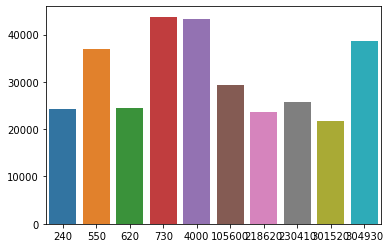

In [41]:
sns.barplot(x = clean_df['game_ids'].value_counts().index[0:10], y = clean_df['game_ids'].value_counts().values[0:10])

In [42]:
clean_df['game_ids'].value_counts()

730       43776
4000      43301
304930    38682
550       37044
105600    29239
          ...  
438160        1
473920        1
355460        1
400380        1
404200        1
Name: game_ids, Length: 9192, dtype: int64

In [43]:
clean_df['game_ids'].value_counts()

730       43776
4000      43301
304930    38682
550       37044
105600    29239
          ...  
438160        1
473920        1
355460        1
400380        1
404200        1
Name: game_ids, Length: 9192, dtype: int64

<AxesSubplot:>

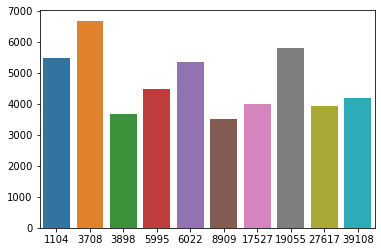

In [44]:
sns.barplot(x = clean_df['user_ids'].value_counts().index[0:10], y = clean_df['user_ids'].value_counts().values[0:10])

<AxesSubplot:>

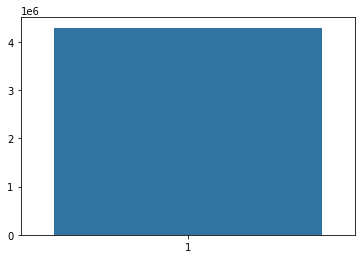

In [45]:
sns.barplot(x=clean_df['owned'].value_counts().index,y=clean_df['owned'].value_counts().values)

In [47]:
dates = pd.to_datetime(game_df['release_date'],errors='coerce')

In [50]:
dates.dropna(inplace=True)

In [51]:
dates

0       2018-01-04
1       2018-01-04
2       2017-07-24
3       2017-12-07
5       2018-01-04
           ...    
32129   2018-01-04
32130   2018-01-04
32131   2018-01-04
32132   2018-01-04
32133   2017-09-02
Name: release_date, Length: 29894, dtype: datetime64[ns]

In [54]:
dates[0].month

1

In [56]:
month_holder =[]
for date in dates:
    month_holder.append(date.month)

In [58]:
month_series = pd.Series(month_holder)

<AxesSubplot:>

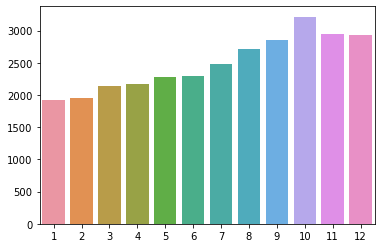

In [61]:
sns.barplot(x = month_series.value_counts().index,y=month_series.value_counts().values)

In [64]:
year_holder =[]
for date in dates:
    year_holder.append(date.year)
year_series = pd.Series(year_holder)

<AxesSubplot:xlabel='release_date', ylabel='Count'>

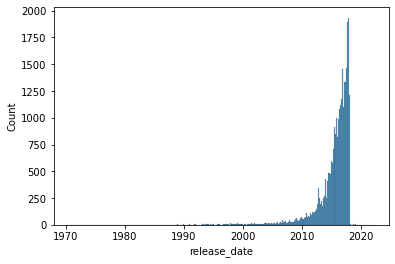

In [68]:
sns.histplot(dates)

<AxesSubplot:>

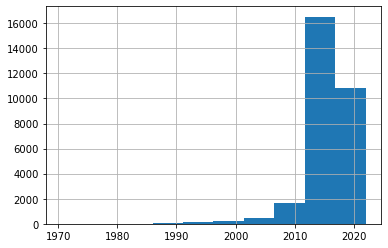

In [70]:
dates.hist()

[Text(0, 0, 'Ubisoft - San Francisco'),
 Text(1, 0, 'SmiteWorks USA, LLC'),
 Text(2, 0, 'Dovetail Games'),
 Text(3, 0, 'KOEI TECMO GAMES CO., LTD.'),
 Text(4, 0, 'Paradox Development Studio'),
 Text(5, 0, 'Capcom'),
 Text(6, 0, 'Ronimo Games'),
 Text(7, 0, 'Choice of Games'),
 Text(8, 0, 'Musopia'),
 Text(9, 0, 'Stainless Games')]

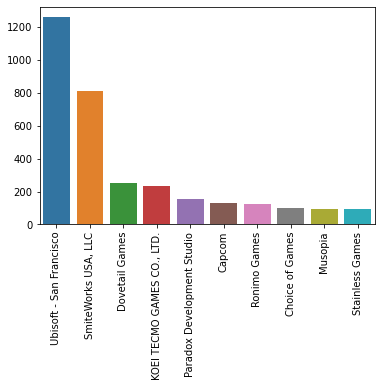

In [78]:
developers = sns.barplot(x=game_df['developer'].value_counts().index[0:10],y=game_df['developer'].value_counts().values[0:10])
developers.set_xticklabels(labels =game_df['developer'].value_counts().index[0:10], rotation=90)

<AxesSubplot:>

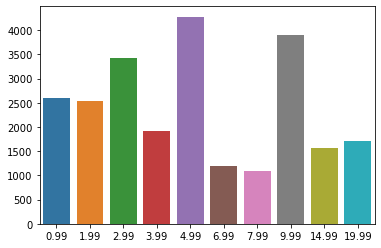

In [83]:
game_df['price'].value_counts()
sns.barplot(x=game_df['price'].value_counts().index[0:10],y=game_df['price'].value_counts().values[0:10])


<AxesSubplot:>

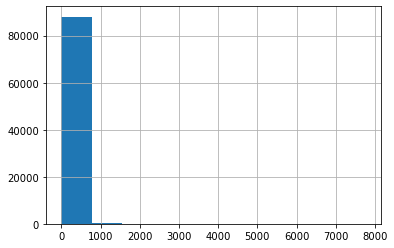

In [87]:
item_df['items_count'].hist()
#sns.histplot(item_df['items_count'])

### Making the df include the zeros

In [48]:
clean_df_pivot = clean_df.pivot(index=['user_ids'],columns=['game_ids'],values='owned')

In [49]:
clean_df_pivot = clean_df_pivot.fillna(0)

In [50]:
clean_df_pivot

game_ids,10,20,30,40,50,60,70,80,130,220,...,527440,527510,527520,527810,527890,527900,528580,528660,529820,530720
user_ids,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
clean_df_melt = clean_df_pivot.melt(var_name='game_ids', value_name='owned',ignore_index=False)

In [52]:
clean_df_melt

,game_ids,owned
user_ids,,
0,10,1.0
1,10,1.0
2,10,0.0
3,10,1.0
4,10,1.0
...,...,...
88303,530720,0.0
88304,530720,0.0
88305,530720,0.0


In [54]:
clean_df_melt.index.value_counts()

88277    9192
26420    9192
26437    9192
26436    9192
26443    9192
         ... 
53727    9192
53726    9192
53721    9192
53720    9192
0        9192
Name: user_ids, Length: 69304, dtype: int64

In [56]:
clean_df_melt.reset_index(inplace=True)

In [57]:
clean_df_melt

,user_ids,game_ids,owned
0,0,10,1.0
1,1,10,1.0
2,2,10,0.0
3,3,10,1.0
4,4,10,1.0
...,...,...,...
637042363,88303,530720,0.0
637042364,88304,530720,0.0
637042365,88305,530720,0.0
637042366,88306,530720,0.0


# Modeling

### Surprise SVD Matrix Factorization

## _Changed clean_df to clean_df_melt to add the 0's_

In [89]:
reader = Reader(rating_scale=(0,1))
data = Dataset.load_from_df(clean_df,reader)

In [90]:
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  69304 

Number of items:  9192


In [75]:
params = {'n_factors': [20, 50, 100],
         'reg_all': [0.02, 0.05, 0.1]}
g_s_svd = GridSearchCV(SVD,param_grid=params,n_jobs=-1,random_state=22)
g_s_svd.fit(data)

KeyboardInterrupt: 

In [50]:
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 0.001248365643820949, 'mae': 0.0001893696793780434}
{'rmse': {'n_factors': 20, 'reg_all': 0.1}, 'mae': {'n_factors': 20, 'reg_all': 0.1}}


### KNN Model - currently not able to run without crashing

In [ ]:
# knn_basic = KNNBasic(sim_options={'name':'pearson', 'user_based':True})
# cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)

In [ ]:
# for i in cv_knn_basic.items():
#     print(i)
# print('-----------------------')
# print(np.mean(cv_knn_basic['test_rmse']))

# ALS Model

In [82]:
als = cross_validate(BaselineOnly(bsl_options={'method':'als'}), data, cv=5, verbose=True, n_jobs=-1)
als

Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
MAE (testset)     0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
Fit time          2.55    2.58    2.43    1.91    2.11    2.31    0.26    
Test time         7.14    6.63    6.08    6.14    5.20    6.24    0.64    


{'test_rmse': array([0., 0., 0., 0., 0.]),
 'test_mae': array([0., 0., 0., 0., 0.]),
 'fit_time': (2.5484118461608887,
  2.582180976867676,
  2.4280691146850586,
  1.906214952468872,
  2.1097910404205322),
 'test_time': (7.139643907546997,
  6.629882097244263,
  6.082101821899414,
  6.139932870864868,
  5.202011823654175)}

# SGD model

In [83]:
sgd = cross_validate(BaselineOnly(bsl_options={'method':'sgd'}), data, cv=5, verbose=True, n_jobs=-1)
sgd

Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
MAE (testset)     0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
Fit time          7.08    7.35    8.09    7.53    6.40    7.29    0.56    
Test time         7.07    9.13    7.30    6.96    5.15    7.12    1.26    


{'test_rmse': array([0., 0., 0., 0., 0.]),
 'test_mae': array([0., 0., 0., 0., 0.]),
 'fit_time': (7.079278230667114,
  7.354934930801392,
  8.086459875106812,
  7.533876895904541,
  6.39642858505249),
 'test_time': (7.0661702156066895,
  9.131999969482422,
  7.297684192657471,
  6.96480393409729,
  5.149333953857422)}

# NMF model

In [84]:
nmf = cross_validate(NMF(random_state=22), data, cv=5, verbose=True, n_jobs=-1)
nmf

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0596  0.0596  0.0597  0.0596  0.0597  0.0596  0.0001  
MAE (testset)     0.0595  0.0595  0.0596  0.0595  0.0596  0.0595  0.0000  
Fit time          250.26  253.35  258.03  251.56  248.20  252.28  3.33    
Test time         9.13    12.47   10.33   9.70    9.73    10.27   1.17    


{'test_rmse': array([0.05957598, 0.05961096, 0.0597083 , 0.05959952, 0.05967888]),
 'test_mae': array([0.0594827 , 0.05951473, 0.05960006, 0.05950714, 0.05957729]),
 'fit_time': (250.25756096839905,
  253.34569096565247,
  258.02878308296204,
  251.5647919178009,
  248.20341396331787),
 'test_time': (9.12648892402649,
  12.474567890167236,
  10.334890842437744,
  9.695861101150513,
  9.726248025894165)}

In [86]:
normal_pred = cross_validate(NormalPredictor(), data, cv=5, verbose=True, n_jobs=-1)
normal_pred

Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
MAE (testset)     0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
Fit time          3.59    3.68    4.40    3.04    3.14    3.57    0.48    
Test time         9.34    11.16   8.04    7.26    5.70    8.30    1.85    


{'test_rmse': array([0., 0., 0., 0., 0.]),
 'test_mae': array([0., 0., 0., 0., 0.]),
 'fit_time': (3.5929839611053467,
  3.678424119949341,
  4.40342116355896,
  3.039043664932251,
  3.142571210861206),
 'test_time': (9.340185642242432,
  11.1648690700531,
  8.035531044006348,
  7.261898994445801,
  5.7023468017578125)}

In [87]:
co_clustering = cross_validate(CoClustering(random_state=22), data, cv=5, verbose=True, n_jobs=-1)
co_clustering

Evaluating RMSE, MAE of algorithm CoClustering on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
MAE (testset)     0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
Fit time          68.94   68.52   79.98   68.65   61.00   69.42   6.07    
Test time         10.99   10.81   7.34    7.36    7.02    8.70    1.80    


{'test_rmse': array([0., 0., 0., 0., 0.]),
 'test_mae': array([0., 0., 0., 0., 0.]),
 'fit_time': (68.94433379173279,
  68.51907205581665,
  79.97802686691284,
  68.64549899101257,
  60.99839997291565),
 'test_time': (10.990592956542969,
  10.812081813812256,
  7.340562105178833,
  7.360296249389648,
  7.019043922424316)}

In [105]:
co_clustering['test_rmse']

array([0., 0., 0., 0., 0.])

In [89]:
slope_one = cross_validate(SlopeOne(), data, cv=5, verbose=True, n_jobs=-1)
slope_one

KeyboardInterrupt: 

In [ ]:
svd = cross_validate(SVD(random_state=22), data, cv=5, verbose=True, n_jobs=-1)
svd

In [ ]:
svdpp = cross_validate(SVDpp(random_state=22), data, cv=5, verbose=True, n_jobs=-1)
svd

In [100]:
algorithms = [SVD(),BaselineOnly(bsl_options={'method':'als'}),BaselineOnly(bsl_options={'method':'sgd'}), NMF(), NormalPredictor(), CoClustering(random_state=22),SlopeOne()]

In [104]:
holder = []
for algo in [SVD(),BaselineOnly(bsl_options={'method':'als'}),BaselineOnly(bsl_options={'method':'sgd'}), NMF(), NormalPredictor(), CoClustering(),SlopeOne()]:
    results = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False, n_jobs=-1)
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algo).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    holder.append(tmp)
pd.DataFrame(holder).set_index('Algorithm').sort_values('test_rmse')    

,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,0.000000,2.262155,6.325219
BaselineOnly,0.000000,6.903510,6.570454
NormalPredictor,0.000000,3.265561,7.415964
CoClustering,0.000000,66.406169,10.742900
SlopeOne,0.000000,113.980058,416.939957
SVD,0.011291,236.203990,9.572822
NMF,0.059590,222.205336,8.244623


# Deep learning model

In [63]:
clean_df

,user_ids,game_ids,owned
0,0,10,1
1,1,10,1
2,3,10,1
3,4,10,1
4,10,10,1
...,...,...,...
4294252,74089,375450,1
4294253,85030,353390,1
4294254,86026,354280,1
4294255,86588,433920,1


In [64]:
dl_x = clean_df.drop(['owned'],axis=1)

In [70]:
dl_y = clean_df['owned'].astype(np.float32)

In [79]:
val_indx = get_cv_idxs(len(clean_df))

NameError: name 'get_cv_idxs' is not defined

In [ ]:
dl_data = ColumnarModelData.from_data_frame(path, val_indx, dl_x, dl_y, ['user_ids', 'game_ids'], 64)

In [51]:
svd = SVD(n_factors= 20, reg_all=0.1)
svd.fit(dataset)

In [52]:
svd.predict(2, 4)

Prediction(uid=2, iid=4, r_ui=None, est=0.9999885299547432, details={'was_impossible': False})

In [53]:
merged_df['game_ids'].value_counts().head(50)

730       43776
4000      43301
304930    38682
550       37044
105600    29239
230410    25807
620       24465
240       24220
218620    23729
301520    21785
49520     21029
218230    20726
340       19826
227940    19721
400       18774
220       18307
236390    18172
333930    17233
208090    16489
8190      16272
252490    16201
224260    15979
219640    15930
320       15854
322330    15571
8930      15303
24240     15202
33930     15084
55230     14753
1250      14216
35420     14000
304050    13969
360       13327
380       13275
22380     13131
420       13060
42910     12239
200210    12105
8870      11967
252950    11605
204360    11511
113200    11400
222880    11368
221100    10923
17410     10846
291480    10794
265630    10723
407530    10493
323370    10484
291550    10322
Name: game_ids, dtype: int64

Create a new user using 4 random games from the list above of the top 50 most popular games

In [54]:
user_play = [{'user_ids': 100000, 'game_ids': 730, 'owned': 1},
 {'user_ids': 100000, 'game_ids': 400, 'owned': 1},
 {'user_ids': 100000, 'game_ids': 204360, 'owned': 1},
 {'user_ids': 100000, 'game_ids': 17410, 'owned': 1}]

Add the new user to the dataset

In [55]:
new_games_df = clean_df.append(user_play,ignore_index=True)
new_data = Dataset.load_from_df(new_games_df,reader)

In [56]:
svd_ = SVD(n_factors= 20, reg_all=0.1)
svd_.fit(new_data.build_full_trainset())

Loop through all of the games and make predictions on those games for the new user

In [57]:
list_of_games = []
for g_id in clean_df['game_ids'].unique():
    list_of_games.append((g_id,svd_.predict(100000,g_id)[3]))

user: 100000     item: 10         r_ui = None   est = 1.00   {'was_impossible': False}
user: 100000     item: 20         r_ui = None   est = 1.00   {'was_impossible': False}
user: 100000     item: 30         r_ui = None   est = 1.00   {'was_impossible': False}
user: 100000     item: 40         r_ui = None   est = 1.00   {'was_impossible': False}
user: 100000     item: 50         r_ui = None   est = 1.00   {'was_impossible': False}
user: 100000     item: 60         r_ui = None   est = 1.00   {'was_impossible': False}
user: 100000     item: 70         r_ui = None   est = 1.00   {'was_impossible': False}
user: 100000     item: 130        r_ui = None   est = 1.00   {'was_impossible': False}
user: 100000     item: 300        r_ui = None   est = 1.00   {'was_impossible': False}
user: 100000     item: 240        r_ui = None   est = 1.00   {'was_impossible': False}
user: 100000     item: 3830       r_ui = None   est = 1.00   {'was_impossible': False}
user: 100000     item: 2630       r_ui = No

In [58]:
game_pred = sorted(list_of_games, key=lambda x:x[1], reverse=True)

A function that predicts new recommendations for the user

In [59]:
def recommended_games(user_play,game_title_df,n):
        for idx, rec in enumerate(user_play):
            title = game_title_df.loc[game_title_df['game_ids'] == int(rec[0])]['app_name']
            first_title = title.iloc[0]
            print('Recommendation # ', idx+1, ': ', first_title, '\n')
            n-= 1
            if n == 0:
                break

In [60]:
recommended_games(game_pred,merged_df,5)

Recommendation #  1 :  Team Fortress Classic 

Recommendation #  2 :  Day of Defeat 

Recommendation #  3 :  Half-Life: Opposing Force 

Recommendation #  4 :  Ricochet 

Recommendation #  5 :  Half-Life 

